# Load prediction from energy bills - Predictors Testing

## Description
This Jupyter Notebook is designed to support the Bill2Watt project, which focuses on predicting energy consumption based on time-of-use (ToU) energy bills.
The notebook utilizes the bill2watt package, a collection of data-driven methods for energy consumption prediction.

The goal of the Bill2Watt project is to provide and compare models that can predict energy consumption patterns based on ToU energy bills.
Hence, this notebook provides an end-to-end workflow for training and testing various predictors and evaluating their performance.
It includes all the necessary steps for data loading, preprocessing, prediction with different methods, cross-validation, performance evaluation, and results visualization.


## Requirements
To run this notebook successfully, the following requirements should be met:
- Python 3.x
- bill2watt package
- scikit-learn
- pandas
- numpy
- os
- scipy
- matplotlib
- tqdm

## Content of the cells

### 1. Import Statement
This section imports the necessary libraries and modules for data loading, data management, utility functions, and data visualization.

### 2. Output Settings
Here, the output folder and file saving settings are specified. You can choose whether to save CSV files and figures generated during the execution of the notebook.

### 3. Load the Training/Testing Dataset
The training/testing dataset is loaded from the 'dataset.csv' file located in the same folder as the notebook.
The dataset contains information about energy bills, including user codes, months, types of end users, classes, categories, and values of x (ToU energy bill) and y (hourly typical load profile).

### 4. Tests Settings
In this section, tests to evaluate different predictors are defined, which include: FlatPredictor, SLPPredictor, CategoryPredictor, ClassificationPredictor, and RegressionPredictor from bill2watt.predictors.
Here, parameters for each predictor can be specified.

### 5. Normalization
The X and Y data are normalized row-wise to remove magnitude effects. XRowNormalizer and YRowNormalizer from bill2watt.utils.normalizing are used for normalization.

### 6. Training/Test splitting
The X and Y data are split into training and test datasets. Batches for leave-one-group-out (LOGO) cross-validation are created based on end users.

### 7. Test Various Predictors
This section executes each test defined in the previous section. It predicts the energy consumption values using different predictors and performs LOGO cross-validation.

### 8. Performance Evaluation
Here, the performances of the various predictors are evaluated using different error metrics such as absolute error, energy distance, and duration curve error. The metrics are calculated for each predictor based on the predicted values.

### 9. Save Predicted Values
The predicted X and Y values for each test are saved in CSV files for future use.

## Usage
The following settings can be modified within the notebook:

- Output folder, figures and files settings (Section 2)
- Parameters and models for each predictor (Section 4)

To change these settings, locate the corresponding sections in the notebook and modify the relevant code.
Please note that modifying other parts of the notebook may affect its functionality.

## Reference and citation
Please refer to the file [README.md](README.md) for instructions.

## Info
- Author: G. Lorenti
- Email: gianmarco.lorenti@polito.it

In [1]:
# Import statement

# Data loading and management
import numpy as np
import pandas as pd
import os

# Utilities for data-driven methods
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from scipy import stats

# From bill2watt package
from bill2watt.common.common import js, fs, ni, nh
from bill2watt.utils.normalizing import XRowNormalizer, YRowNormalizer
from bill2watt.utils.utils import eval_x, spread_y
from bill2watt.predictors.flat_predictor import FlatPredictor
from bill2watt.predictors.slp_predictor import SLPPredictor
from bill2watt.predictors.category_predictor import CategoryPredictor
from bill2watt.predictors.classification_predictor import ClassificationPredictor
from bill2watt.predictors.regression_predictor import RegressionPredictor

# Data visualization and fancy stuff
from tqdm import tqdm
from matplotlib import pyplot as plt
from plotting import create_radar_plot, create_row_boxplots

In [2]:
# Output settings
# Here, we specify some settings for file and plot outputs

# Output folder
os.makedirs(out_path := 'Output/Example', exist_ok=True)

# Files and figures saving settings
save_csv = True # turn tu True to save the files
save_figs = True  # turn tu True to save the figures
fmt = 'png'  # format for saving the figures
dpi = 600  # dpi for saving the figures

In [3]:
# Load the training/testing dataset

try:
    data = pd.read_csv('dataset.csv', sep=';', index_col=[0, 1])
except FileNotFoundError:
    raise FileNotFoundError("File 'dataset.csv' must be in the same folder as this notebook.")

# Columns names
col_user = 'user'  # code of the end user (in index)
col_month = 'month'  # number of the month (in index)
col_type = 'type'  # type of end user
col_class = 'class'  # class of end user
col_category = 'category'  # category of end user
cols_nd = [f"nd_j{j}" for j in js]  # number of days of each day-type in the month
cols_x = [f"x_f{f}" for f in fs]  # values of the x (ToU energy bill)
cols_y = [f"y_i{i}" for i in range(ni)]  # values of the y (hourly typical load profile)

# Visualize the dataset
data.head(12)

type class             category  nd_j0  nd_j1  nd_j2     x_f1  \
user   month                                                                 
bta5_6 1      bta  bta5  cultural_and_sports     20      4      7  221.760   
       2      bta  bta5  cultural_and_sports     20      4      4  224.623   
       3      bta  bta5  cultural_and_sports     23      4      4  276.134   
       4      bta  bta5  cultural_and_sports     21      4      5  186.458   
       5      bta  bta5  cultural_and_sports     21      4      6  205.442   
       6      bta  bta5  cultural_and_sports     21      4      5  224.155   
       7      bta  bta5  cultural_and_sports     22      5      4  169.361   
       8      bta  bta5  cultural_and_sports     22      4      5  197.543   
       9      bta  bta5  cultural_and_sports     22      4      4  202.346   
       10     bta  bta5  cultural_and_sports     21      5      5  221.844   
       11     bta  bta5  cultural_and_sports     21      4      5  256.213   
       12     bta  bta5  cultural_and_sports     22      3      6  258.846   

                 x_f2      x_f3      y_i0  ...     y_i62     y_i63     y_i64  \
user   month                               ...                                 
bta5_6 1      191.148  306.0460  0.690200  ...  0.953714  1.928571  1.617000   
       2      181.216  242.4760  0.593050  ...  1.375500  1.903500  1.362000   
       3      195.086  272.3115  0.577218  ...  1.246250  2.691750  2.315750   
       4      184.092  241.3430  0.714048  ...  0.450200  0.450000  0.962600   
       5      161.405  288.0050  0.587571  ...  1.565500  1.519500  1.386833   
       6      143.920  250.1660  0.919238  ...  0.527600  0.959800  1.082800   
       7      145.230  228.7770  0.611318  ...  0.470500  0.470000  0.470000   
       8      128.508  223.6940  0.909864  ...  0.964600  0.485800  0.959600   
       9      159.409  243.9060  0.654136  ...  1.650500  1.365000  0.640750   
       10     216.094  261.9675  0.575571  ...  0.611400  0.967400  1.214000   
       11     176.428  279.2550  0.594429  ...  1.332000  1.469000  1.693400   
       12     164.988  296.0620  0.688955  ...  1.527833  1.462500  0.821000   

                 y_i65     y_i66     y_i67     y_i68     y_i69     y_i70  \
user   month                                                               
bta5_6 1      1.294429  2.101715  1.229429  0.750286  0.727286  0.713000   
       2      1.841000  1.163250  2.554250  1.531500  1.298750  0.722000   
       3      1.038750  2.151000  2.907250  1.535000  1.207250  0.714750   
       4      0.855200  0.473800  1.138800  0.806800  0.798200  0.708800   
       5      1.268500  1.180500  1.179333  1.244667  1.761333  1.029000   
       6      0.972200  1.123200  1.706800  0.914800  1.477200  0.723200   
       7      0.526500  0.667250  1.262250  1.342500  0.789000  1.109250   
       8      0.473600  0.492400  0.778400  1.146400  0.729800  0.694400   
       9      0.927750  0.853750  1.171500  2.322000  1.172750  0.744250   
       10     1.302800  3.193200  2.189600  1.381200  0.962600  0.681800   
       11     1.916400  1.767600  1.917000  1.502800  0.798400  0.910600   
       12     2.007000  2.729666  2.023333  1.167667  0.869333  0.710833   

                 y_i71  
user   month            
bta5_6 1      0.579143  
       2      0.583500  
       3      0.610750  
       4      0.573800  
       5      0.572833  
       6      0.575600  
       7      0.822250  
       8      0.567000  
       9      0.857000  
       10     0.578400  
       11     0.927000  
       12     1.034167  

[12 rows x 81 columns]

In [4]:
# Tests settings
# Here, we specify the different tests to run, i.e., predictor that are going to be tested

# Categories predictor
# NOTE: see 'CategoriesPredictor' class' doc for further detail
category = col_class  # identify new SLPs by grouping end users in the training set by class

# Classification predictor
# NOTE: see 'ClassificationPredictor' class' doc for further detail
clustering = KMeans(n_clusters=11)  # identify centers of typical load profiles
classifier = DecisionTreeClassifier()  # identify decision rule to assign bills to cluster centers

# Classification predictor
# NOTE: see 'ClassificationPredictor' class' doc for further detail
regressor = KNeighborsRegressor(n_neighbors=9)

tests = dict(
    flat=dict(label='Flat', predictor=FlatPredictor),
    slp=dict(label='SLP', predictor=SLPPredictor),
    categories=dict(label='Categories', predictor=CategoryPredictor, predictor_kwargs=dict(category=col_class)),
    classification=dict(label='Classification', predictor=ClassificationPredictor,
                        predictor_kwargs=dict(clustering=clustering, classifier=classifier)),
    regression=dict(label='Regression', predictor=RegressionPredictor, predictor_kwargs=dict(regressor=regressor))
)

In [5]:
# Normalization
# Here, we normalize the X and Y data along the rows
# NOTE: normalization is performed row-wise, to remove 'magnitude' effects of the different samples (i.e., end users)

x_row_norm, y_row_norm = XRowNormalizer(), YRowNormalizer()

# NOTE: the original magnitude is kept in the attribute 'x_sum' of the normalizers, however, we use a new DataFrame
data_norm = data.copy()
data_norm[cols_x] = x_row_norm.fit_transform(data[cols_x].values)
data_norm[cols_y] = y_row_norm.fit_transform(data[cols_x].values, data[cols_y].values)

# Visualize normalized data
data_norm.head(12)

type class             category  nd_j0  nd_j1  nd_j2      x_f1  \
user   month                                                                  
bta5_6 1      bta  bta5  cultural_and_sports     20      4      7  0.308448   
       2      bta  bta5  cultural_and_sports     20      4      4  0.346472   
       3      bta  bta5  cultural_and_sports     23      4      4  0.371382   
       4      bta  bta5  cultural_and_sports     21      4      5  0.304723   
       5      bta  bta5  cultural_and_sports     21      4      6  0.313723   
       6      bta  bta5  cultural_and_sports     21      4      5  0.362569   
       7      bta  bta5  cultural_and_sports     22      5      4  0.311687   
       8      bta  bta5  cultural_and_sports     22      4      5  0.359336   
       9      bta  bta5  cultural_and_sports     22      4      4  0.334091   
       10     bta  bta5  cultural_and_sports     21      5      5  0.316963   
       11     bta  bta5  cultural_and_sports     21      4      5  0.359902   
       12     bta  bta5  cultural_and_sports     22      3      6  0.359560   

                  x_f2      x_f3      y_i0  ...     y_i62     y_i63     y_i64  \
user   month                                ...                                 
bta5_6 1      0.265870  0.425682  0.000960  ...  0.001327  0.002682  0.002249   
       2      0.279518  0.374010  0.000915  ...  0.002122  0.002936  0.002101   
       3      0.262378  0.366241  0.000776  ...  0.001676  0.003620  0.003115   
       4      0.300857  0.394420  0.001167  ...  0.000736  0.000735  0.001573   
       5      0.246476  0.439802  0.000897  ...  0.002391  0.002320  0.002118   
       6      0.232789  0.404642  0.001487  ...  0.000853  0.001552  0.001751   
       7      0.267277  0.421035  0.001125  ...  0.000866  0.000865  0.000865   
       8      0.233759  0.406905  0.001655  ...  0.001755  0.000884  0.001746   
       9      0.263198  0.402710  0.001080  ...  0.002725  0.002254  0.001058   
       10     0.308747  0.374290  0.000822  ...  0.000874  0.001382  0.001735   
       11     0.247828  0.392269  0.000835  ...  0.001871  0.002064  0.002379   
       12     0.229183  0.411257  0.000957  ...  0.002122  0.002032  0.001140   

                 y_i65     y_i66     y_i67     y_i68     y_i69     y_i70  \
user   month                                                               
bta5_6 1      0.001800  0.002923  0.001710  0.001044  0.001012  0.000992   
       2      0.002840  0.001794  0.003940  0.002362  0.002003  0.001114   
       3      0.001397  0.002893  0.003910  0.002064  0.001624  0.000961   
       4      0.001398  0.000774  0.001861  0.001319  0.001304  0.001158   
       5      0.001937  0.001803  0.001801  0.001901  0.002690  0.001571   
       6      0.001573  0.001817  0.002761  0.001480  0.002389  0.001170   
       7      0.000969  0.001228  0.002323  0.002471  0.001452  0.002041   
       8      0.000861  0.000896  0.001416  0.002085  0.001328  0.001263   
       9      0.001532  0.001410  0.001934  0.003834  0.001936  0.001229   
       10     0.001861  0.004562  0.003128  0.001973  0.001375  0.000974   
       11     0.002692  0.002483  0.002693  0.002111  0.001122  0.001279   
       12     0.002788  0.003792  0.002811  0.001622  0.001208  0.000987   

                 y_i71  
user   month            
bta5_6 1      0.000806  
       2      0.000900  
       3      0.000821  
       4      0.000938  
       5      0.000875  
       6      0.000931  
       7      0.001513  
       8      0.001031  
       9      0.001415  
       10     0.000826  
       11     0.001302  
       12     0.001437  

[12 rows x 81 columns]

In [6]:
# Training/test datasets
# Here, we split X and Y and create batches for leave-one-group-out cross-validation

x_data, y_data = data_norm[cols_x], data_norm[cols_y]

# Store also 'nd' (number of days) data, needed for 'flat' approach
nd_data = data[cols_nd]

# Store also users categorization data, needed for 'categories' approach
categ_data = data[[col_type, col_class, col_category]]

# Create batches for leave-one-group-out (LOGO) cross-validation
# NOTE: each group is composed of the samples from a single end user (typically, 12)
for index in (y_data.index, nd_data.index, categ_data.index):
    assert (index == x_data.index).all(), \
        "Indices of 'x_data', 'y_data', 'nd_data' and 'categ_data' must match to avoid issues when splitting."
make_groups = lambda:\
    LeaveOneGroupOut().split(x_data, groups=data.index.get_level_values(col_user))

# Visualize
print(f"Data split into {len(list(make_groups()))} groups of training/test sets")

Data split into 114 groups of training/test sets


In [7]:
# Test various predictors
# Here, we re-built the whole dataset using the different predictors through a LOGO cross-validation

# Execute each test
for test in tests.values():
    print(f"Evaluating test: {test['label']}")

    # Get test details
    predictor = test['predictor']
    predictor_kwargs = test.get('predictor_kwargs', dict())

    # Initialize output
    y_test = y_data.copy()
    x_test = x_data.copy()

    # Easy-exits if test is not 'data-driven'

    # Flat predictor
    if predictor is FlatPredictor:
        y_test.loc[:] = predictor().predict(x_data.values, nd_data.values)

    # SLP predictor
    elif predictor is SLPPredictor:
        keys = list(categ_data.reset_index().set_index([col_type, col_month]).index)
        y_test.loc[:] = predictor().predict(x_data.values, keys)

    # Other (data-driven) predictors
    else:
        # Perform LOGO cross-validation
        for group in tqdm(list(make_groups())):

            # Get train/test data
            train_indices, test_indices = group
            x_train = x_data.loc[x_data.index[train_indices]].copy()
            y_train = y_data.loc[y_data.index[train_indices]].copy()
            x_test_ = x_data.loc[x_data.index[test_indices]].copy()

            # For 'CategoryPredictor' type, the procedure is a bit different...
            if predictor is CategoryPredictor:
                # Get categories to be added to training/testing data
                categ_train = categ_data.loc[categ_data.index[train_indices]]
                categ_test = categ_data.loc[categ_data.index[test_indices]]
                x_train = categ_train.join(x_train).set_index(
                    list(categ_train.columns), append=True)
                y_train = categ_train.join(y_train).set_index(
                    list(categ_train.columns), append=True)
                # "Predict" based on categories
                y_test_ = predictor(x_data=x_train, y_data=y_train, **predictor_kwargs).predict(
                    x_test_, categ_test[predictor_kwargs['category']])

            # For other predictors, the procedure is easier
            else:
                y_test_ = predictor(x_data=x_train, y_data=y_train,
                                    **predictor_kwargs).predict(x_test_)

            # Store the predicted values
            y_test.loc[y_test.index[test_indices]] = y_test_

    # Re-evaluate the bill
    x_test.loc[:] = np.array([eval_x(y_, nd_) for y_, nd_ in zip(y_test.values, nd_data.values)])

    # Ensure predicted values are normalized
    y_test.loc[:] = YRowNormalizer().fit_transform(x_test.values, y_test.values)
    x_test.loc[:] = XRowNormalizer().fit_transform(x_test.values)

    test['y_data'] = y_test
    test['x_data'] = x_test

Evaluating test: Flat
Evaluating test: SLP
Evaluating test: Categories


100%|██████████| 114/114 [00:01<00:00, 107.59it/s]


Evaluating test: Classification


100%|██████████| 114/114 [00:11<00:00, 10.03it/s]


Evaluating test: Regression


100%|██████████| 114/114 [00:00<00:00, 197.85it/s]


In [8]:
# Performance evaluation
# Here, we evaluate the performances of the various predictors according to different error metrics

# Useful function used to evaluate performances

def absolute_error(y_true, y_pred):
    """Evaluate the total absolute error between the input 'y_true' and 'y_pred'."""
    return np.abs(y_true - y_pred).sum()

def energy_distance(y_true, y_pred, nd):
    """
    Evaluate the energy distance between the input 'y_true' and 'y_pred', using 'nd' as weights
    of the samples. See scipy.stats.energy_distance for further details.
    """
    weights = np.repeat(nd, nh)
    return stats.energy_distance(y_true, y_pred, u_weights=weights, v_weights=weights)

def duration_curve_error(y_true, y_pred, nd):
    """
    Evaluate the duration curve error between the input 'y_true' and 'y_pred', using 'nd' to generate
    a synthetic monthly profile. See bill2watt.utils.util.spread_y for further details.
    """
    dc_true = np.sort(spread_y(y_true, nd))
    dc_pred = np.sort(spread_y(y_pred, nd))
    return absolute_error(dc_true, dc_pred)

def f_absolute_error(row, y_true=y_data):
    """Apply 'absolute_error' along rows of predicted 'y_pred' pandas.DataFrame."""
    return absolute_error(y_true.loc[row.name].values, row.values)

def f_energy_distance(row, y_true=y_data, nd=nd_data):
    """Apply 'energy_distance' along rows of predicted 'y_pred' pandas.DataFrame."""
    return energy_distance(y_true.loc[row.name].values, row.values, nd.loc[row.name].values)

def f_duration_curve_error(row, y_true=y_data, nd=nd_data):
    """Apply 'duration_curve_error' along rows of predicted 'y_pred' pandas.DataFrame."""
    return duration_curve_error(y_true.loc[row.name].values, row.values, nd.loc[row.name].values)

def f_y_diff(y):
    """Apply np.diff to rows of 'y', using periodicity so that the output has same size as the input."""
    return pd.concat((y, y.iloc[:,:1]), axis=1).T.apply(np.diff, axis=0).T

# Calculate performance for each predictor
print("Evaluating tests")
for test in tqdm(tests.values()):

    # Get predicted data
    x_pred = test['x_data']
    y_pred = test['y_data']

    # For extreme safety, check indices matching
    assert (x_pred.index == x_data.index).all(), "Indices of predicted and original X data must match,"
    assert (y_pred.index == y_data.index).all(), "Indices of predicted and original Y data must match,"

    # Evaluate metrics

    # Absolute error on the X values
    x_error = x_pred.apply(f_absolute_error, axis=1, y_true=x_data)

    # Absolute error on the Y values (weighted on 'nd')
    y_error = {col: y_pred.iloc[:, j*nh:(j+1)*nh].apply(
        f_absolute_error, axis=1, args=(y_data.iloc[:, j*nh:(j+1)*nh],))
        for j, col in enumerate(cols_nd)}
    y_error = (pd.DataFrame(y_error) * nd_data).sum(axis=1)

    # Absolute error on the duration curve (syntethic, using 'nd')
    dc_error = y_pred.apply(f_duration_curve_error, axis=1)

    # Energy Distance on the distribution of y (weighted on 'nd')
    e_distance = y_pred.apply(f_energy_distance, axis=1)

    # Energy Distance on the distribution of y "difference", i.e., rate of change between time steps
    e_distance_diff = f_y_diff(y_pred).apply(f_energy_distance, axis=1, args=(f_y_diff(y_data),))

    test['metrics'] = pd.DataFrame({'x_error': x_error,
                                    'y_error': y_error,
                                    'dc_error': dc_error,
                                    'e_distance': e_distance,
                                    'e_distance_diff': e_distance_diff,
                                    })

Evaluating tests


100%|██████████| 5/5 [00:07<00:00,  1.43s/it]


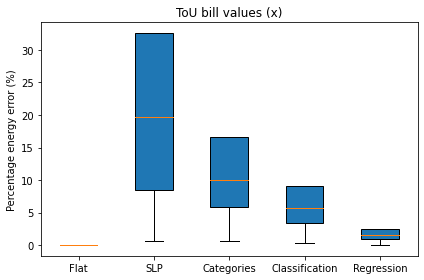

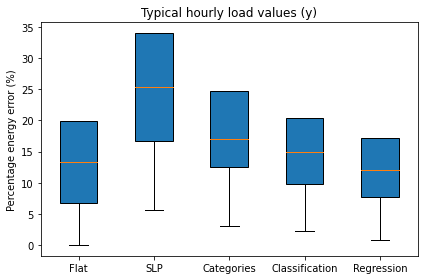

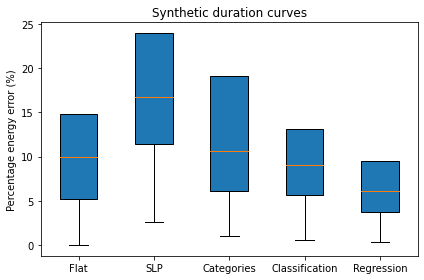

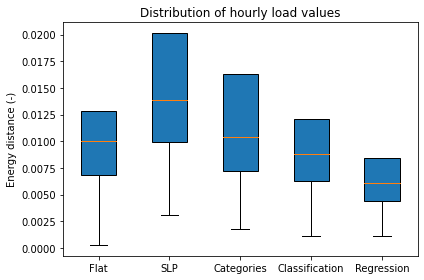

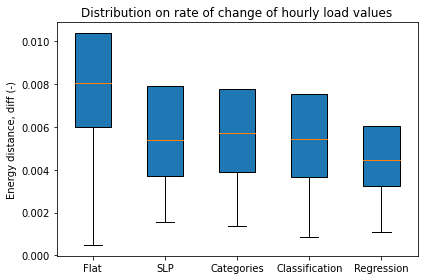

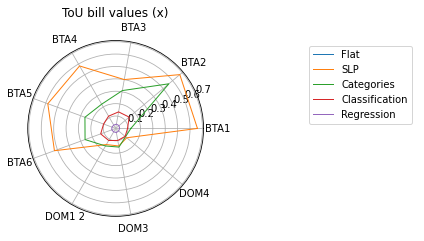

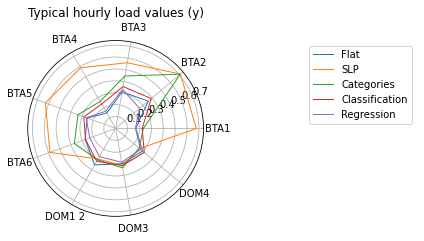

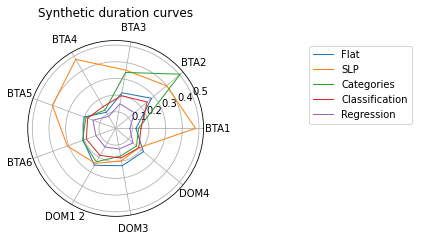

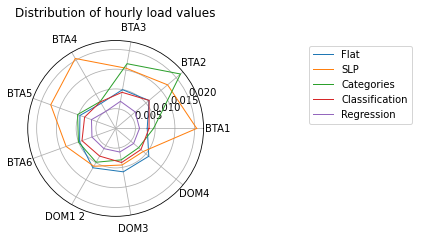

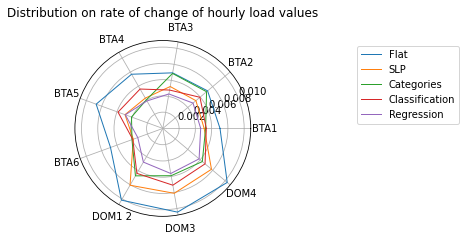

In [17]:
# Output processing and visualization
# Here we process the output so to organize by metric and compare the tests, both in terms of
# error on all the samples and error divided by 'class' of end users

# Settings for plotting and visualization of the different metrics
metrics = dict(x_error=dict(ylabel='Percentage energy error (%)',
                            multiplier=50,  # N.B. The total error measures twice the energy put in the wronng time step, moreover, we want a percentage --> 1/2*1000
                            title='ToU bill values (x)'),
               y_error=dict(ylabel='Percentage energy error (%)',
                            multiplier=50,
                            title='Typical hourly load values (y)'),
               dc_error=dict(ylabel='Percentage energy error (%)',
                            multiplier=50,
                             title='Synthetic duration curves'),
               e_distance=dict(ylabel='Energy distance (-)',
                               title='Distribution of hourly load values'),
               e_distance_diff=dict(ylabel='Energy distance, diff (-)',
                               title='Distribution on rate of change of hourly load values'),
)

# Create a collection of dataframes showing the tests along the rows and, for
# each test, the error in all samples along the columns
metrics_samples = dict()

# Then, evaluate median and IQR of the errors (for each metric separately) for
# each test divided by 'class' of end user
metrics_median_class = dict()
metrics_iqr_class = dict()

# Go through all the metrics considered
for key, metric in metrics.items():
    assert all(key in test['metrics'].columns for test in tests.values()), \
        f"All tests have the key {key} in their 'metrics' DataFrame."

    # Select the error metric for each test
    dfs = [test['metrics'][key].to_frame(name) for name, test in tests.items()]

    df = pd.concat(dfs, axis=1)
    class_groups = df.join(categ_data['class']).groupby('class')
    df_median_class = class_groups.median()
    df_iqr_class = class_groups.quantile(0.75) - class_groups.quantile(0.25)

    metrics_samples[key] = df.T
    metrics_median_class[key] = df_median_class.T
    metrics_iqr_class[key] = df_iqr_class.T

# Boxplot of the errors on all samples for the different tests
for key, metric in metrics.items():

    # Check that the metric is within the metrics calculated
    assert key in metrics_samples, f"{key} must be in 'metric_samples"

    # Multiply values for visualization
    multiplier = metric.pop('multiplier', 1)
    df = metrics_samples[key] * multiplier

    # Create boxplot
    fig = create_row_boxplots(df, xticklabels=df.index.map({name: tests[name]['label']
                                                            for name in tests}), **metric)

    plt.show()

# Radar plot of the median error divided by 'class' of end user for the different tests
for key, metric in metrics.items():

    # Check that the metric is within the metrics calculated
    assert key in metrics_median_class, f"{key} must be in 'metric_median_class"

    # Multiply values for visualization
    multiplier = metric.pop('multiplier', 1)
    df = metrics_median_class[key] * multiplier

    # Create radar plot
    fig = create_radar_plot(df, labels=df.index.map({name: tests[name]['label'] for name in tests}),
                            xticklabels=df.columns.str.upper().str.replace('_', ' '), **metric)

    plt.show()

In [10]:
# Save predicted values
# Here, we save the predicted values in csv files for future uses

# Save predicted X and Y for each test
for name, test in tests.items():
    x_test = test['x_data']
    y_test = test['y_data']
    predicted_data = data.copy()
    predicted_data[cols_x] = x_row_norm.inverse_transform(x_test.values)
    predicted_data[cols_y] = y_row_norm.inverse_transform(y_test.values)
    predicted_data.to_csv(os.path.join(out_path, f"dataset_{name}.csv"), sep=';', index=True)